# Analysis of available taxonomic data from JGI Dataset
Zach Flinkstrom - 14Mar2024

In [362]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
import scanpy as sc
import anndata
import plotly.express as px
from scipy.stats import linregress, kruskal
import scikit_posthocs

In [298]:
#Get file names
files = glob.glob('data/download*/' + '/**/*.txt', recursive=True)

In [299]:
assert(len(files)==5154) #should be 5154

In [300]:
def file_to_df(filepath):
    """Takes filepath of taxonomic composition table and converts it into cleaned pandas dataframe with the following columns:
    Index is the full domain+phylum name, domain-only column, phylum-only column, abundance column, and relative abundance column"""
    df = pd.read_csv(filepath, sep='\n')
    values = [int(i[-1]) for i in df.iloc[1:,0].str.split()]
    domain_phylum = ['_'.join(i[0:-1]) for i in df.iloc[1:,0].str.split()]
    domain = ['_'.join(i[0:-1]).split(':')[0] for i in df.iloc[1:,0].str.split()]
    phyla = ['_'.join(i[0:-1]).split(':')[1] for i in df.iloc[1:,0].str.split()]
    new_df = pd.DataFrame({'domain':domain, 'phylum':phyla, 'abundance':values}, index=domain_phylum)
    new_df['rel_abundance'] = new_df.abundance/new_df.abundance.sum()*100
    return new_df

In [301]:
#Create dictionary to map filenames to taxon id
ids = pd.read_csv('data/taxonomic_composition_files_ids.csv')
ids_from_filename = [int(i.split('.')[0].split('_')[-1]) for i in ids.file_name]
match = [ids_from_filename[i]==ids.taxon_oid[i] for i in range(len(ids_from_filename))]
ids = ids.iloc[match, :]

In [302]:
data_dict = {} #store taxonomic composition dataframes in a dictionary with taxon_oid as key and dataframe as value
for filepath in files:
    if any(filepath.split('/')[-1] in x for x in ids.file_name):
        data_dict[int(filepath.split('/')[-1].split('.')[0].split('_')[-1])] = file_to_df(filepath)

In [303]:
archaea = []
bacteria = []
eukaryota = []
viruses = []
for key in data_dict.keys():
    df = data_dict[key]
    groupby = df.groupby('domain').sum()['rel_abundance']
    archaea.append(groupby.Archaea)
    bacteria.append(groupby.Bacteria)
    eukaryota.append(groupby.Eukaryota)
    viruses.append(groupby.Viruses)

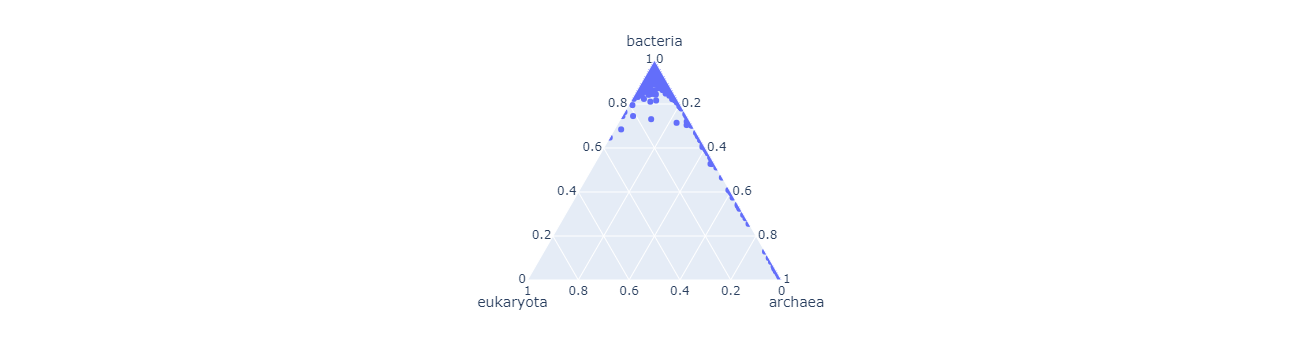

In [304]:
df = pd.DataFrame({'bacteria':bacteria, 'archaea':archaea, 'eukaryota':eukaryota, 'viruses':viruses})
fig = px.scatter_ternary(df, a="bacteria", b="eukaryota", c="archaea")
fig.show()

## Integrate clustering information

In [309]:
metadata = pd.read_csv('output/adata_obs_metadata.csv', index_col=0)
metadata.head()

,Domain,Sequencing Status,Study Name,Genome Name / Sample Name,Sequencing Center,IMG Genome ID,IMG Release/Pipeline Version,IMG Submission ID,Add Date,Assembly Method,...,Estimated number of genomes - Marker genes median * assembled,Estimated number of genomes - Marker genes mode * assembled,JGI Data Utilization Status,Number of Filtered Reads * assembled,Number of Mapped Reads * assembled,Pipeline,% Assembled Reads * assembled,Average Coverage of Assembled Sequences * assembled,source,kmeans
3300007174,*Microbiome,Permanent Draft,Deep subsurface shale carbon reservoir microbi...,Lab enriched deep subsurface shale carbon rese...,DOE Joint Genome Institute (JGI),3300007174,IMG Annotation Pipeline v.4.10.0,77333,2016-03-10,MEGAHIT v. MEGAHIT v1.0.3,...,14,13,Unrestricted,0,0,4,0.0,0.0,Environmental,Cluster 3
3300007255,*Microbiome,Permanent Draft,Vadose zone soil and rhizosphere microbial com...,Vadose zone soil and rhizosphere microbial com...,DOE Joint Genome Institute (JGI),3300007255,IMG Annotation Pipeline v.4.10.2,77318,2016-03-30,MEGAHIT v. MEGAHIT v1.0.3,...,173,0,Unrestricted,0,0,4,0.0,0.0,Roots,Cluster 1
3300007258,*Microbiome,Permanent Draft,Vadose zone soil and rhizosphere microbial com...,Vadose zone soil and rhizosphere microbial com...,DOE Joint Genome Institute (JGI),3300007258,IMG Annotation Pipeline v.4.10.0,77319,2016-03-30,MEGAHIT v. MEGAHIT v1.0.3,...,183,159,Unrestricted,0,0,4,0.0,0.0,Roots,Cluster 1
3300007265,*Microbiome,Permanent Draft,Vadose zone soil and rhizosphere microbial com...,Vadose zone soil microbial communities from th...,DOE Joint Genome Institute (JGI),3300007265,IMG Annotation Pipeline v.4.10.2,77320,2016-04-29,MEGAHIT v. MEGAHIT v1.0.3,...,197,0,Unrestricted,0,0,4,0.0,0.0,Roots,Cluster 1
3300007283,*Microbiome,Permanent Draft,Marine microbial communities from the Southern...,Seawater microbial communities from Saanich In...,DOE Joint Genome Institute (JGI),3300007283,IMG Annotation Pipeline v.4.10.0,77334,2016-03-28,MEGAHIT v. MEGAHIT v1.0.3,...,357,0,Unrestricted,0,0,4,0.0,0.0,Marine,Cluster 2


In [310]:
#Make sure data dict and metadata id keys line up
assert(len(set(data_dict.keys())-set(metadata.index))==0)

In [311]:
metadata = metadata[metadata.index.isin(list(data_dict.keys()))]

In [312]:
len(data_dict.keys())

4988

In [313]:
len(metadata.index)

4988

In [314]:
#Calculate abundance of domains for each entry in metadata
archaea = []
bacteria = []
eukaryota = []
viruses = []
for key in metadata.index:
    df = data_dict[key]
    groupby = df.groupby('domain').sum()['rel_abundance']
    archaea.append(groupby.Archaea)
    bacteria.append(groupby.Bacteria)
    eukaryota.append(groupby.Eukaryota)
    viruses.append(groupby.Viruses)

In [315]:
#Create new columns in metadata for the abundance values
metadata['bacteria_rel_abundance'] = bacteria
metadata['archaea_rel_abundance'] = archaea
metadata['eukaryota_rel_abundance'] = eukaryota
metadata['virus_rel_abundance'] = viruses

## Abundance across clusters

In [392]:
metadata.groupby('kmeans').median()[['bacteria_rel_abundance', 'archaea_rel_abundance','eukaryota_rel_abundance','virus_rel_abundance']]

,bacteria_rel_abundance,archaea_rel_abundance,eukaryota_rel_abundance,virus_rel_abundance
kmeans,,,,
Cluster 1,98.961824,0.454832,0.289396,0.020546
Cluster 2,95.196787,0.223627,1.428044,1.635259
Cluster 3,95.447338,3.694306,0.238841,0.092155


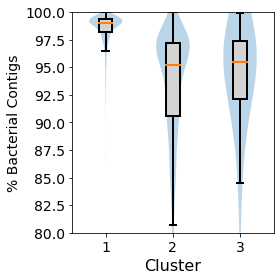

In [382]:
plt.figure(figsize=(4,4))

props = {'linewidth':2}
plt.boxplot([metadata[metadata.kmeans=='Cluster 1']['bacteria_rel_abundance'],
               metadata[metadata.kmeans=='Cluster 2']['bacteria_rel_abundance'],
               metadata[metadata.kmeans=='Cluster 3']['bacteria_rel_abundance']],
           widths=0.2, showfliers=False, patch_artist=True, boxprops={'linewidth':2, 'facecolor':'lightgray'}, whiskerprops=props, capprops=props, medianprops=props)

plt.violinplot([metadata[metadata.kmeans=='Cluster 1']['bacteria_rel_abundance'],
               metadata[metadata.kmeans=='Cluster 2']['bacteria_rel_abundance'],
               metadata[metadata.kmeans=='Cluster 3']['bacteria_rel_abundance']], showmedians=False, showextrema=False)

plt.ylabel('% Bacterial Contigs', size=14)
plt.yticks(size=14)
plt.ylim([80, 100])
plt.xticks([1,2,3],fontsize=14)
plt.xlabel('Cluster', size=16)

plt.tight_layout()
plt.savefig('figures/Clusters_percent_bacteria.png', facecolor='white', dpi=300)
plt.show()

In [369]:
kruskal(metadata[metadata.kmeans=='Cluster 1']['bacteria_rel_abundance'],
               metadata[metadata.kmeans=='Cluster 2']['bacteria_rel_abundance'],
               metadata[metadata.kmeans=='Cluster 3']['bacteria_rel_abundance'])

KruskalResult(statistic=2157.3598253188734, pvalue=0.0)

In [376]:
scikit_posthocs.posthoc_dunn([metadata[metadata.kmeans=='Cluster 1']['bacteria_rel_abundance'],
               metadata[metadata.kmeans=='Cluster 2']['bacteria_rel_abundance'],
               metadata[metadata.kmeans=='Cluster 3']['bacteria_rel_abundance']], p_adjust='Bonferroni')

,1,2,3
1,1.000000e+00,0.000000,7.309371e-252
2,0.000000e+00,1.000000,2.857711e-01
3,7.309371e-252,0.285771,1.000000e+00


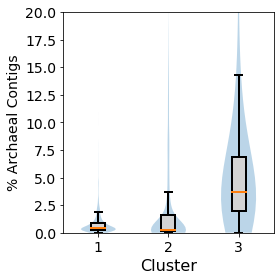

In [383]:
plt.figure(figsize=(4,4))
props = {'linewidth':2}
plt.boxplot([metadata[metadata.kmeans=='Cluster 1']['archaea_rel_abundance'],
               metadata[metadata.kmeans=='Cluster 2']['archaea_rel_abundance'],
               metadata[metadata.kmeans=='Cluster 3']['archaea_rel_abundance']],
           widths=0.2, showfliers=False, patch_artist=True, boxprops={'linewidth':2, 'facecolor':'lightgray'}, whiskerprops=props, capprops=props, medianprops=props)

plt.violinplot([metadata[metadata.kmeans=='Cluster 1']['archaea_rel_abundance'],
               metadata[metadata.kmeans=='Cluster 2']['archaea_rel_abundance'],
               metadata[metadata.kmeans=='Cluster 3']['archaea_rel_abundance']], showmedians=False, showextrema=False)

plt.ylabel('% Archaeal Contigs', size=14)
plt.yticks(size=14)
plt.xticks([1,2,3],fontsize=14)
plt.xlabel('Cluster', size=16)
plt.ylim([0, 20])

plt.tight_layout()
plt.savefig('figures/Clusters_percent_archaea.png', facecolor='white', dpi=300)
plt.show()

In [367]:
kruskal(metadata[metadata.kmeans=='Cluster 1']['archaea_rel_abundance'],
               metadata[metadata.kmeans=='Cluster 2']['archaea_rel_abundance'],
               metadata[metadata.kmeans=='Cluster 3']['archaea_rel_abundance'])

KruskalResult(statistic=1325.5476437994384, pvalue=1.4487264824787271e-288)

In [375]:
scikit_posthocs.posthoc_dunn([metadata[metadata.kmeans=='Cluster 1']['archaea_rel_abundance'],
               metadata[metadata.kmeans=='Cluster 2']['archaea_rel_abundance'],
               metadata[metadata.kmeans=='Cluster 3']['archaea_rel_abundance']], p_adjust='Bonferroni')

,1,2,3
1,1.000000e+00,2.567723e-08,1.027486e-218
2,2.567723e-08,1.000000e+00,1.505602e-258
3,1.027486e-218,1.505602e-258,1.000000e+00


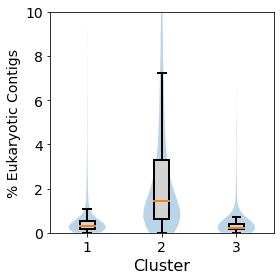

In [384]:
plt.figure(figsize=(4,4))
props = {'linewidth':2}
plt.boxplot([metadata[metadata.kmeans=='Cluster 1']['eukaryota_rel_abundance'],
               metadata[metadata.kmeans=='Cluster 2']['eukaryota_rel_abundance'],
               metadata[metadata.kmeans=='Cluster 3']['eukaryota_rel_abundance']],
           widths=0.2, showfliers=False, patch_artist=True, boxprops={'linewidth':2, 'facecolor':'lightgray'}, whiskerprops=props, capprops=props, medianprops=props)

plt.violinplot([metadata[metadata.kmeans=='Cluster 1']['eukaryota_rel_abundance'],
               metadata[metadata.kmeans=='Cluster 2']['eukaryota_rel_abundance'],
               metadata[metadata.kmeans=='Cluster 3']['eukaryota_rel_abundance']], showmedians=False, showextrema=False)

plt.ylabel('% Eukaryotic Contigs', size=14)
plt.yticks(size=14)
plt.ylim([0, 10])
plt.xticks([1,2,3],fontsize=14)
plt.xlabel('Cluster', size=16)

plt.tight_layout()
plt.savefig('figures/Clusters_percent_eukaryote.png', facecolor='white', dpi=300)
plt.show()

In [363]:
kruskal(metadata[metadata.kmeans=='Cluster 1']['eukaryota_rel_abundance'],
               metadata[metadata.kmeans=='Cluster 2']['eukaryota_rel_abundance'],
               metadata[metadata.kmeans=='Cluster 3']['eukaryota_rel_abundance'])

KruskalResult(statistic=1414.319411107287, pvalue=7.663762786424326e-308)

In [377]:
scikit_posthocs.posthoc_dunn([metadata[metadata.kmeans=='Cluster 1']['eukaryota_rel_abundance'],
               metadata[metadata.kmeans=='Cluster 2']['eukaryota_rel_abundance'],
               metadata[metadata.kmeans=='Cluster 3']['eukaryota_rel_abundance']], p_adjust='Bonferroni')

,1,2,3
1,1.000000e+00,1.016905e-238,7.037653e-07
2,1.016905e-238,1.000000e+00,2.610716e-217
3,7.037653e-07,2.610716e-217,1.000000e+00


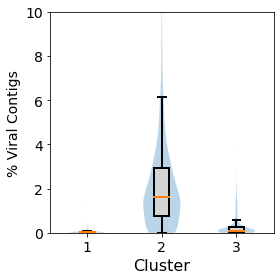

In [385]:
plt.figure(figsize=(4,4))
props = {'linewidth':2}
plt.boxplot([metadata[metadata.kmeans=='Cluster 1']['virus_rel_abundance'],
               metadata[metadata.kmeans=='Cluster 2']['virus_rel_abundance'],
               metadata[metadata.kmeans=='Cluster 3']['virus_rel_abundance']],
           widths=0.2, showfliers=False, patch_artist=True, boxprops={'linewidth':2, 'facecolor':'lightgray'}, whiskerprops=props, capprops=props, medianprops=props)

plt.violinplot([metadata[metadata.kmeans=='Cluster 1']['virus_rel_abundance'],
               metadata[metadata.kmeans=='Cluster 2']['virus_rel_abundance'],
               metadata[metadata.kmeans=='Cluster 3']['virus_rel_abundance']], showmedians=False, showextrema=False)

plt.ylabel('% Viral Contigs', size=14)
plt.yticks(size=14)
plt.ylim([0, 10])
plt.xticks([1,2,3],fontsize=14)
plt.xlabel('Cluster', size=16)

plt.tight_layout()
plt.savefig('figures/Clusters_percent_virus.png', facecolor='white', dpi=300)
plt.show()

In [386]:
kruskal(metadata[metadata.kmeans=='Cluster 1']['virus_rel_abundance'],
               metadata[metadata.kmeans=='Cluster 2']['virus_rel_abundance'],
               metadata[metadata.kmeans=='Cluster 3']['virus_rel_abundance'])

KruskalResult(statistic=2836.4198195213844, pvalue=0.0)

In [387]:
scikit_posthocs.posthoc_dunn([metadata[metadata.kmeans=='Cluster 1']['virus_rel_abundance'],
               metadata[metadata.kmeans=='Cluster 2']['virus_rel_abundance'],
               metadata[metadata.kmeans=='Cluster 3']['virus_rel_abundance']], p_adjust='Bonferroni')

,1,2,3
1,1.000000e+00,0.000000e+00,8.187280e-110
2,0.000000e+00,1.000000e+00,2.549980e-105
3,8.187280e-110,2.549980e-105,1.000000e+00


## Relationship to GC content

LinregressResult(slope=0.3778710396490724, intercept=19.668775910722395, rvalue=0.35649704225314827, pvalue=2.1732056862494615e-149, stderr=0.014024785886654949)


(80.0, 100.0)

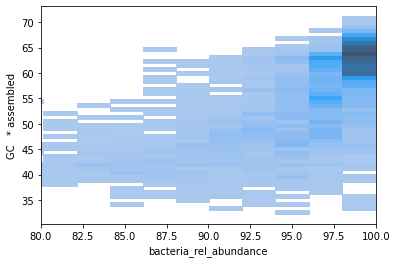

In [393]:
print(linregress(metadata.bacteria_rel_abundance, metadata['GC   * assembled']))
sns.histplot(x=metadata.bacteria_rel_abundance, y=metadata['GC   * assembled'], bins=50)
plt.xlim([80, 100])

LinregressResult(slope=-0.19702011480880288, intercept=56.2194865665858, rvalue=-0.1751239008323669, pvalue=1.2095651478948894e-35, stderr=0.015686469089651822)


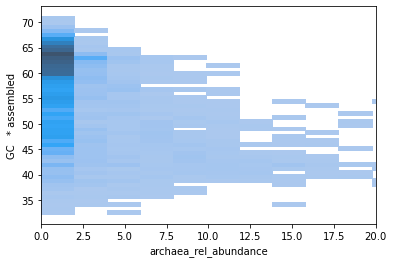

In [394]:
print(linregress(metadata.archaea_rel_abundance, metadata['GC   * assembled']))
sns.histplot(x=metadata.archaea_rel_abundance, y=metadata['GC   * assembled'], bins=50)
plt.xlim([0, 20])
plt.show()

LinregressResult(slope=-1.0626133866696998, intercept=57.07059218496057, rvalue=-0.28769685769913034, pvalue=1.1272969309449553e-95, stderr=0.05009602596163633)


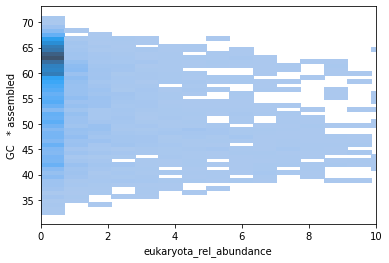

In [395]:
print(linregress(metadata.eukaryota_rel_abundance, metadata['GC   * assembled']))
sns.histplot(x=metadata.eukaryota_rel_abundance, y=metadata['GC   * assembled'], bins=50)
plt.xlim([0, 10])
plt.show()

LinregressResult(slope=-3.1049037759508824, intercept=58.113424921062744, rvalue=-0.5649059468513479, pvalue=0.0, stderr=0.06422905849693877)


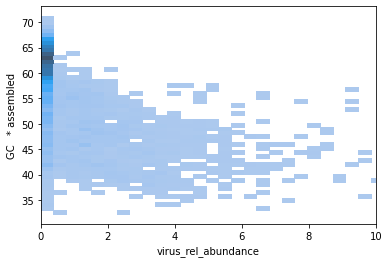

In [396]:
print(linregress(metadata.virus_rel_abundance, metadata['GC   * assembled']))
sns.histplot(x=metadata.virus_rel_abundance, y=metadata['GC   * assembled'], bins=50)
plt.xlim([0, 10])
plt.show()